In [20]:
import numpy as np
import pandas as pd 
import lifelines as ll
import matplotlib.pyplot as plt
import plotly as py
import plotly.tools as tls   
from time import time
from scipy.stats import chisquare, chi2_contingency, spearmanr
from random import seed, shuffle

First of all we define some functions for our purpose: 

## GI Scores
Load data from [Mapping the Genetic Landscape of Human Cells](https://www.sciencedirect.com/science/article/pii/S0092867418307359?via%3Dihub#mmc2) paper. 
> [**Table S5.**](https://www.sciencedirect.com/science/article/pii/S0092867418307359?via%3Dihub#mmc5)

In [21]:
def get_SLdataset(SL_thr = 1):
    # read data from file 
    myfile = ("CRISPRi_Mapping_paper/Table_S5.xlsx") 
    xl = pd.ExcelFile(myfile)
    sheets = {sheet: xl.parse(sheet) for sheet in xl.sheet_names}
    # print ('Sheets:')
    # print (xl.sheet_names)
    # Read data from *gene GI scores sheet*:
    GIsheet = sheets['gene GI scores and correlations']
    raw_data = pd.DataFrame(data = {
        'Gene1': np.array(GIsheet['Unnamed: 0'][3:]),
        'Gene2': np.array(GIsheet['Unnamed: 1'][3:]), 
        'K562': np.array(GIsheet['K562.4'][3:]),                # g1 <-> g2 GI scores
        'Jurkat': np.array(GIsheet['Jurkat.4'][3:])             # g1 <-> g2 GI scores
    })
    raw_K562   = raw_data.drop(columns='Jurkat').dropna()
    raw_Jurkat = raw_data.drop(columns='K562').dropna()
    K562   = raw_K562[(raw_K562['K562'] > SL_thr) & 
                      (raw_K562['Gene1'] != raw_K562['Gene2'])].reset_index(drop=True)
    Jurkat = raw_Jurkat[(raw_Jurkat['Jurkat'] > SL_thr) &
                        (raw_Jurkat['Gene1'] != raw_Jurkat['Gene2'])].reset_index(drop=True)
    print (f'K562: {round(100* len(K562) / len(raw_K562), 2)}%', end = '\t') 
    print (f'{len(K562)} SLs from {len(raw_K562)} unique gene pairs')
    print (f'Jurkat: {round(100* len(Jurkat) / len(raw_Jurkat), 2)}%', end = '\t') 
    print (f'{len(Jurkat)} SLs from {len(raw_Jurkat)} unique gene pairs ')
    return {'K562':K562, 'Jurkat':Jurkat}

## Read expression data


In [22]:
# make final data set 
def make_study_dataset(filepath, get_RNASeq = False):
    t0 = time()
    with open(filepath) as fp:
        lines = [l.split('\t') for l in fp.readlines()]
        # switch NAs -> 0s
        for i,l in enumerate(lines):
            if 'NA' in l:
                n = len(l[2:])
                l = l[0:2]
                for z in [0]*n:
                    l.append(z)
            lines[i] = l
        genes = [d[0] for d in lines[1:]]
        RNA_seq = [np.array(d[2:], dtype = float) for d in lines[1:]]
                     
        Q1 = [np.quantile(p, 0.25) for p in RNA_seq]       # Low expression threshold
        Q3 = [np.quantile(p, 0.75) for p in RNA_seq]       # High expression threshold        
        
    data = pd.DataFrame(data = [i + j for i,j in zip([-1*(p <= q1) for p,q1 in zip(RNA_seq, Q1)], 
                                                     [ 1*(p >= q3) for p,q3 in zip(RNA_seq, Q3)])],
                        index = [d[0] for d in lines[1:]], columns= lines[0][2:])
        

    print("done in %fs" % (time() - t0))       
    if get_RNASeq == False:
        return data
    else:
        RNA_seq = pd.DataFrame(data = RNA_seq, index = [d[0] for d in lines[1:]],
                               columns= lines[0][2:])
        return RNA_seq, data

## Statistical Test 

In [23]:
def SL_stat_test(filename, cell_line = 'K562'):
    t0 = time()
    SLdata = get_SLdataset()
    RNASeq, data = make_study_dataset(filename, get_RNASeq = True)
    tmp = SLdata[cell_line]
    # filter out missing gene names between GI and expression studies 
    tmp = tmp[pd.DataFrame(tmp.Gene1.tolist()).isin(data.index.tolist()).any(1)].reset_index(drop=True)
    tmp = tmp[pd.DataFrame(tmp.Gene2.tolist()).isin(data.index.tolist()).any(1)].reset_index(drop=True)
    Cors = []
    Obs = []
    for g1,g2 in zip(tmp.Gene1,tmp.Gene2):    # g1   g2
        Obs.append([
            [sum(np.array(data.loc[g1] < 0)
             * np.array(data.loc[g2] < 0)),   # low_low
             sum(np.array(data.loc[g1] > 0)
             * np.array(data.loc[g2] < 0))],   # high_low
            [sum(np.array(data.loc[g1] < 0)
             * np.array(data.loc[g2] > 0)),  # low_high
             sum(np.array(data.loc[g1] > 0)
             * np.array(data.loc[g2] > 0))]   # high_high
         ])
        Cors.append (spearmanr(np.array(data.loc[g1]), np.array(data.loc[g2]))[0])
    # do chi-square test:
    chi2_res = [chi2_contingency(o) for o in np.array(Obs)]
    Chi2 = [c[0] for c in chi2_res]
    ChiPval = [p[1] for p in chi2_res]
    Exp = [np.concatenate((x[3][0], x[3][1])) for x in chi2_res]
    Obs = [np.concatenate((o[0], o[1])) for o in Obs]         
    # make the test result dataframe:
    test_res = pd.DataFrame(data= np.concatenate((
        np.stack(( tmp.Gene1 ,tmp.Gene2, tmp[cell_line]), axis = 1),
        np.array(Obs), np.array(Exp), np.stack(( ChiPval, Chi2, Cors), axis = 1),
        ), axis = 1), columns=[
        'Gene1', 'Gene2', 'GI_Score',
        'Obs_Low_Low', 'Obs_High_Low', 'Obs_Low_High', 'Obs_High_High',
        'Exp_Low_Low' ,'Exp_High_Low', 'Exp_Low_High', 'Exp_High_High', 
        'ChiPval', 'Chi2', 'Correlation'])
    print("done in %fs" % (time() - t0))
    return test_res

In [32]:
def random_test(filename, cell_line = 'K562'):
    t0 = time()
    SLdata = get_SLdataset(SL_thr = -50)
    RNASeq, data = make_study_dataset(filename, get_RNASeq = True)
    tmp = SLdata[cell_line]
    # filter out missing gene names between GI and expression studies 
    tmp = tmp[pd.DataFrame(tmp.Gene1.tolist()).isin(data.index.tolist()).any(1)].reset_index(drop=True)
    tmp = tmp[pd.DataFrame(tmp.Gene2.tolist()).isin(data.index.tolist()).any(1)].reset_index(drop=True)
    Cors = []
    Obs = []
    Gene1 = tmp.Gene1.tolist()
    Gene2 = tmp.Gene2.tolist()
    shuffle(Gene1)
    shuffle(Gene2)
    for i in range (0,5000):
        g1 = Gene1[i]
        g2 = Gene2[i]
        Obs.append([
            [sum(np.array(data.loc[g1] < 0)
             * np.array(data.loc[g2] < 0)),   # low_low
             sum(np.array(data.loc[g1] > 0)
             * np.array(data.loc[g2] < 0))],   # high_low
            [sum(np.array(data.loc[g1] < 0)
             * np.array(data.loc[g2] > 0)),  # low_high
             sum(np.array(data.loc[g1] > 0)
             * np.array(data.loc[g2] > 0))]   # high_high
         ])
        Cors.append (spearmanr(np.array(data.loc[g1]), np.array(data.loc[g2]))[0])
    # do chi-square test:
    chi2_res = [chi2_contingency(o) for o in np.array(Obs)]
    Chi2 = [c[0] for c in chi2_res]
    ChiPval = [p[1] for p in chi2_res]
    Exp = [np.concatenate((x[3][0], x[3][1])) for x in chi2_res]
    Obs = [np.concatenate((o[0], o[1])) for o in Obs]         
    # make the test result dataframe:
    random_test_res = pd.DataFrame(data= np.concatenate((
        np.array(Obs), np.array(Exp), np.stack(( ChiPval, Chi2, Cors), axis = 1)), axis = 1), columns=[
        'Obs_Low_Low', 'Obs_High_Low', 'Obs_Low_High', 'Obs_High_High',
        'Exp_Low_Low' ,'Exp_High_Low', 'Exp_Low_High', 'Exp_High_High', 
        'ChiPval', 'Chi2', 'Correlation'])
    print("done in %fs" % (time() - t0))
    return random_test_res

In [25]:
def stat_test_plot(test,random_test):
    plt.figure()
    plt.subplot(221)
    plt.hist(test.Obs_Low_Low,  alpha=0.5, label='SL') #, histtype=u'step', density=True)
    plt.hist(random_test.Obs_Low_Low,  alpha=0.5, label='Random gene pairs') #, histtype=u'step', density=True)
    plt.legend(loc='upper right')
    plt.xlabel('Obs_Low_Low')
    plt.ylabel('Frequency')
    plt.xlim(-10, 100)
    plt.grid(True)

    plt.subplot(222)
    plt.hist(test.Obs_High_Low,  alpha=0.5, label='SL') #, histtype=u'step', density=True)
    plt.hist(random_test.Obs_High_Low,  alpha=0.5, label='Random gene pairs') #, histtype=u'step', density=True)
    plt.legend(loc='upper right')
    plt.xlabel('Obs_High_Low')
    plt.ylabel('Frequency')
    plt.xlim(-10, 100)
    plt.grid(True)


    plt.subplot(223)
    plt.hist(test.Obs_Low_High,  alpha=0.5, label='SL') #, histtype=u'step', density=True)
    plt.hist(random_test.Obs_Low_High,  alpha=0.5, label='Random gene pairs') #, histtype=u'step', density=True)
    plt.legend(loc='upper right')
    plt.xlabel('Obs_Low_High')
    plt.ylabel('Frequency')
    plt.xlim(-10, 100)
    plt.grid(True)

    # logit
    plt.subplot(224)
    plt.hist(test.Obs_High_High,  alpha=0.5, label='SL') #, histtype=u'step', density=True)
    plt.hist(random_test.Obs_High_High,  alpha=0.5, label='Random gene pairs') #, histtype=u'step', density=True)
    plt.legend(loc='upper right')
    plt.xlabel('Obs_High_High')
    plt.ylabel('Frequency')
    plt.xlim(-10, 100)
    plt.grid(True)
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,
                        wspace=0.35)

    plt.show()

## Survival analysis 
Read combined study clinical data (downloaded from cBioPortal):

In [26]:
def SL_survival(data, test):
    t0 = time()
    clinical_data = pd.read_csv('cBioPortal/combined_study_clinical_data.csv')
    dfs = []
    for t in test:
        survival_data = []
        g1, g2 = t.split('_') 
        g1_index = [ i for i, g in enumerate(data['raw']['Genes']) if g == g1][0]
        g2_index = [ i for i, g in enumerate(data['raw']['Genes']) if g == g2][0]
        Q1g1 = np.quantile(data['raw']['RNA-Seq'][g1_index], 0.25) # Gene 1 threshold
        Q1g2 = np.quantile(data['raw']['RNA-Seq'][g2_index], 0.25) # Gene 2 threshold
        for p, sam in enumerate(data['raw']['sample_ids']):
            dat1 = 1*(data['raw']['RNA-Seq'][data['raw']['Genes'] == g1][p] <= Q1g1)    
            dat2 = 1*(data['raw']['RNA-Seq'][data['raw']['Genes'] == g2][p] <= Q1g2)
            surS = clinical_data['Overall Survival Status'][clinical_data['Sample ID'] == sam]
            surM = clinical_data['Overall Survival (Months)'][clinical_data['Sample ID'] == sam]
            if len(surS) > 0:
                survival_data.append([sam,dat1,dat2,surS.values[0],surM.values[0]])
        dfs.append(
            pd.DataFrame(survival_data, columns=['sample_ids', g1 + ' is low', g2 + ' is low', 
                                                 'Status', 'Months']).dropna()
        )
    print("done in %fs" % (time() - t0))
    return dfs

# Investigate expression patterns 

## 1st
- ### [Acute Myeloid Leukemia (OHSU, Nature 2018)](https://www.cbioportal.org/study?id=aml_ohsu_2018)

In [7]:
# ls cBioPortal/aml_ohsu_2018

In [8]:
# print meta data
with open('cBioPortal/aml_ohsu_2018/meta_study.txt') as fp:
    print( fp.read() )

type_of_cancer: aml
cancer_study_identifier: aml_ohsu_2018
name: Acute Myeloid Leukemia (OHSU, Nature 2018)
description: Whole-exome sequencing of 672 acute myeloid leukemia samples (with 454 matched normals) from the Beat AML program.
citation: Tyner et al. Nature 2018
pmid: 30333627
short_name: AML (OHSU)
groups: PUBLIC


### Chi-square Test

Low-Low gene pairs for **K562** GI pairs:

In [9]:
test = SL_stat_test('cBioPortal/aml_ohsu_2018/data_RNA_Seq_mRNA_median_Zscores.txt', cell_line = 'K562')

K562: 18.08%	18188 SLs from 100576 unique gene pairs
Jurkat: 13.19%	9954 SLs from 75466 unique gene pairs 
done in 10.495267s
done in 229.335654s


> Low Low $Obs/Exp <  $ High High $Obs/Exp$

In [10]:
test[
#     ((test.Obs_Low_Low/ test.Exp_Low_Low) < (test.Obs_High_High/test.Exp_High_High)) 
    (test.Obs_Low_Low < test.Obs_High_High) &
    (test.Obs_Low_Low < test.Obs_Low_High) &
    (test.Obs_Low_Low < test.Obs_High_Low)
    & test.ChiPval < 1e-10
].sort_values('Obs_Low_Low', ascending = False)


,Gene1,Gene2,GI_Score,Obs_Low_Low,Obs_High_Low,Obs_Low_High,Obs_High_High,Exp_Low_Low,Exp_High_Low,Exp_Low_High,Exp_High_High,ChiPval,Chi2,Correlation
3886,CDCA8,CDK1,2.34759,98,0,0,90,51.0851,46.9149,46.9149,43.0851,6.44217e-42,184.014,0.830077
16725,RPL3,RPL5,1.57095,94,0,0,86,49.0889,44.9111,44.9111,41.0889,3.59495e-40,176.014,0.789363
4266,CENPM,RAD51,1.69139,92,0,0,86,47.5506,44.4494,44.4494,41.5506,9.80978e-40,174.018,0.787611
11342,MCM4,ZWINT,1.02414,92,0,1,87,47.5333,44.4667,45.4667,42.5333,2.56784e-39,172.104,0.787611
4744,CLSPN,SKA3,1.27643,92,0,0,79,49.4971,42.5029,42.5029,36.4971,3.34457e-38,167,0.756637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4847,COA3,DLST,1.58947,2,50,76,1,31.4419,20.5581,46.5581,30.4419,2.27854e-26,112.892,-0.544248
4848,COA3,DNTTIP2,1.78078,2,61,60,2,31.248,31.752,30.752,31.248,8.16141e-25,105.799,-0.517699
6177,DCAF7,DNTTIP2,1.58439,2,73,62,0,35.0365,39.9635,28.9635,33.0365,4.37766e-29,125.299,-0.588496
10569,LARS,SNIP1,1.74469,2,56,79,1,34.0435,23.9565,46.9565,33.0435,2.23796e-28,122.061,-0.584071


In [11]:
r_test = random_test('cBioPortal/aml_ohsu_2018/data_RNA_Seq_mRNA_median_Zscores.txt', cell_line = 'K562')

K562: 99.55%	100128 SLs from 100576 unique gene pairs
Jurkat: 99.49%	75078 SLs from 75466 unique gene pairs 
done in 15.412769s
done in 138.679892s


In [37]:
r_test[
#     ((test.Obs_Low_Low/ test.Exp_Low_Low) < (test.Obs_High_High/test.Exp_High_High)) 
    (r_test.Obs_Low_Low < r_test.Obs_High_High) &
    (r_test.Obs_Low_Low < r_test.Obs_Low_High) &
    (r_test.Obs_Low_Low < r_test.Obs_High_Low)
    & r_test.ChiPval < 1e-10
].sort_values('Obs_Low_Low', ascending = False)

,Obs_Low_Low,Obs_High_Low,Obs_Low_High,Obs_High_High,Exp_Low_Low,Exp_High_Low,Exp_Low_High,Exp_High_High,ChiPval,Chi2,Correlation
4403,114.0,0.0,0.0,113.0,57.251101,56.748899,56.748899,56.251101,1.987010e-50,223.017544,1.000000
878,114.0,0.0,0.0,113.0,57.251101,56.748899,56.748899,56.251101,1.987010e-50,223.017544,1.000000
2311,114.0,0.0,0.0,113.0,57.251101,56.748899,56.748899,56.251101,1.987010e-50,223.017544,1.000000
2284,113.0,0.0,0.0,113.0,56.500000,56.500000,56.500000,56.500000,3.283076e-50,222.017699,1.000000
1411,113.0,0.0,0.0,113.0,56.500000,56.500000,56.500000,56.500000,3.283076e-50,222.017699,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
1488,6.0,42.0,65.0,6.0,28.638655,19.361345,42.361345,28.638655,3.374746e-17,71.112213,-0.420354
4827,5.0,64.0,50.0,5.0,30.604839,38.395161,24.395161,30.604839,6.579403e-20,83.436555,-0.459254
1088,3.0,57.0,64.0,2.0,31.904762,28.095238,35.095238,30.904762,3.181445e-24,103.103152,-0.513274
174,3.0,51.0,73.0,2.0,31.813953,22.186047,44.186047,30.813953,9.521002e-25,105.493493,-0.526549


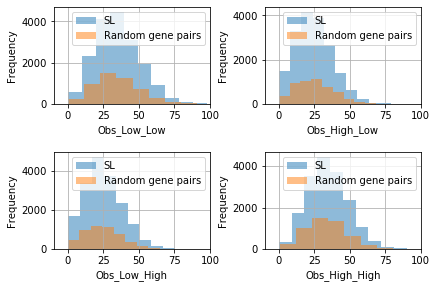

In [13]:
stat_test_plot(test,r_test)

Low-Low gene pairs for **Jurkat** GI pairs:

In [38]:
test = SL_stat_test('cBioPortal/aml_ohsu_2018/data_RNA_Seq_mRNA_median_Zscores.txt', cell_line = 'Jurkat')

K562: 18.08%	18188 SLs from 100576 unique gene pairs
Jurkat: 13.19%	9954 SLs from 75466 unique gene pairs 
done in 14.146837s
done in 165.772767s


> Low Low $Obs/Exp <  $ High High $Obs/Exp$

In [39]:
test[
#     ((test.Obs_Low_Low/ test.Exp_Low_Low) < (test.Obs_High_High/test.Exp_High_High)) 
    (test.Obs_Low_Low < test.Obs_High_High) &
    (test.Obs_Low_Low < test.Obs_Low_High) &
    (test.Obs_Low_Low < test.Obs_High_Low)
    & test.ChiPval < 1e-10
].sort_values('Obs_Low_Low', ascending = False)


,Gene1,Gene2,GI_Score,Obs_Low_Low,Obs_High_Low,Obs_Low_High,Obs_High_High,Exp_Low_Low,Exp_High_Low,Exp_Low_High,Exp_High_High,ChiPval,Chi2,Correlation
9471,SKA3,ZWINT,1.43759,97,0,0,86,51.4153,45.5847,45.5847,40.4153,7.98223e-41,179.008,0.809735
6016,MCM4,ZWINT,1.8278,92,0,1,87,47.5333,44.4667,45.4667,42.5333,2.56784e-39,172.104,0.787611
9193,RPL24,RPL32,1.78545,92,0,0,83,48.3657,43.6343,43.6343,39.3657,4.44691e-39,171.012,0.769175
1923,CDK1,CENPM,2.02748,90,0,0,77,48.503,41.497,41.497,35.503,2.5018e-37,163,0.737394
2378,COA3,NDUFA8,1.74638,89,1,0,65,51.6774,38.3226,37.3226,27.6774,8.09681e-34,146.938,0.675349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2404,COPA,DNTTIP2,1.99321,4,57,71,2,34.1418,26.8582,40.8582,32.1418,3.84663e-25,107.29,-0.538555
3034,DCAF7,PSMD6,1.4455,4,65,50,3,30.541,38.459,23.459,29.541,1.00894e-21,91.6994,-0.476731
3035,DCAF7,RAE1,1.56803,3,53,74,1,32.916,23.084,44.084,30.916,4.8591e-26,111.391,-0.544248
7172,MRPS14,PSMD12,1.55529,2,64,74,2,35.3239,30.6761,40.6761,35.3239,1.69604e-28,122.612,-0.59292


In [40]:
r_test = random_test('cBioPortal/aml_ohsu_2018/data_RNA_Seq_mRNA_median_Zscores.txt', cell_line = 'Jurkat')

K562: 99.55%	100128 SLs from 100576 unique gene pairs
Jurkat: 99.49%	75078 SLs from 75466 unique gene pairs 
done in 14.064156s
done in 127.105408s


In [41]:
r_test[
#     ((test.Obs_Low_Low/ test.Exp_Low_Low) < (test.Obs_High_High/test.Exp_High_High)) 
    (r_test.Obs_Low_Low < r_test.Obs_High_High) &
    (r_test.Obs_Low_Low < r_test.Obs_Low_High) &
    (r_test.Obs_Low_Low < r_test.Obs_High_Low)
    & r_test.ChiPval < 1e-10
].sort_values('Obs_Low_Low', ascending = False)


,Obs_Low_Low,Obs_High_Low,Obs_Low_High,Obs_High_High,Exp_Low_Low,Exp_High_Low,Exp_Low_High,Exp_High_High,ChiPval,Chi2,Correlation
4089,113.0,0.0,0.0,114.0,56.251101,56.748899,56.748899,57.251101,1.987010e-50,223.017544,1.000000
2830,113.0,0.0,0.0,113.0,56.500000,56.500000,56.500000,56.500000,3.283076e-50,222.017699,1.000000
678,113.0,0.0,0.0,113.0,56.500000,56.500000,56.500000,56.500000,3.283076e-50,222.017699,1.000000
1013,113.0,0.0,0.0,113.0,56.500000,56.500000,56.500000,56.500000,3.283076e-50,222.017699,1.000000
3847,113.0,0.0,0.0,113.0,56.500000,56.500000,56.500000,56.500000,3.283076e-50,222.017699,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
3967,3.0,48.0,67.0,3.0,29.504132,21.495868,40.495868,29.504132,3.163337e-22,93.994926,-0.482301
271,3.0,55.0,84.0,1.0,35.286713,22.713287,51.713287,33.286713,1.386539e-28,123.011344,-0.597345
784,2.0,54.0,60.0,1.0,29.675214,26.324786,32.324786,28.675214,7.008345e-24,101.538625,-0.491150
4955,2.0,43.0,74.0,1.0,28.500000,16.500000,47.500000,27.500000,2.600799e-24,103.502392,-0.504425


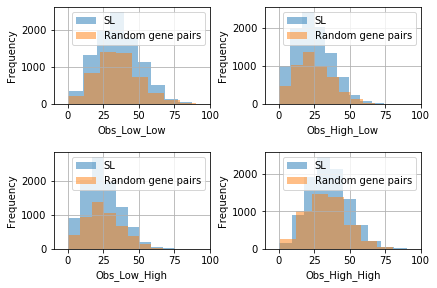

In [42]:
stat_test_plot(test,r_test)

### Survival analysis 

https://plot.ly/python/v3/ipython-notebooks/survival-analysis-r-vs-python/

# 2nd
- ### [Pediatric Acute Lymphoid Leukemia - Phase II (TARGET, 2018)](https://www.cbioportal.org/study?id=all_phase2_target_2018_pub)

In [43]:
# meta data
filepath = 'cBioPortal/all_phase2_target_2018_pub/meta_study.txt'
with open(filepath) as fp:
    print( fp.read() )

type_of_cancer: bll
cancer_study_identifier: all_phase2_target_2018_pub
name: Pediatric Acute Lymphoid Leukemia - Phase II (TARGET, 2018)
short_name: ALL-Phase II (TARGET, 2018)
description: Comprehensive profiling of ALL Phase 2 samples. <p>TARGET data is intended exclusively for biomedical research using pediatric data (i.e., the research objectives cannot be accomplished using data from adults) that focus on the development of more effective treatments, diagnostic tests, or prognostic markers for childhood cancers. Moreover, TARGET data can be used for research relevant to the biology, causes, treatment and late complications of treatment of pediatric cancers, but is not intended for the sole purposes of methods and/or tool development (please see <a href="https://ocg.cancer.gov/programs/target/using-target-data">Using TARGET Data</a> section of the OCG website). If you are interested in using TARGET data for publication or other research purposes, you must follow the <a href="https

In [44]:
# ls cBioPortal/all_phase2_target_2018_pub

In [45]:
data = make_study_dataset('cBioPortal/all_phase2_target_2018_pub/data_RNA_Seq_mRNA_median_Zscores.txt')

done in 10.104318s


### Chi-square Test

Low-Low gene pairs for **K562** GI pairs:

In [46]:
test = SL_stat_test('cBioPortal/all_phase2_target_2018_pub/data_RNA_Seq_mRNA_median_Zscores.txt', cell_line = 'K562')

K562: 18.08%	18188 SLs from 100576 unique gene pairs
Jurkat: 13.19%	9954 SLs from 75466 unique gene pairs 
done in 8.996616s


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 203 and the array at index 1 has size 7

> Low Low $Obs/Exp <  $ High High $Obs/Exp$

In [ ]:
test[
#     ((test.Obs_Low_Low/ test.Exp_Low_Low) < (test.Obs_High_High/test.Exp_High_High)) 
    (test.Obs_Low_Low < test.Obs_High_High) &
    (test.Obs_Low_Low < test.Obs_Low_High) &
    (test.Obs_Low_Low < test.Obs_High_Low)
    & test.ChiPval < 1e-10
].sort_values('Obs_Low_Low', ascending = False)


In [ ]:
r_test = random_test('cBioPortal/all_phase2_target_2018_pub/data_RNA_Seq_mRNA_median_Zscores.txt', cell_line = 'K562')

In [ ]:
r_test[
#     ((test.Obs_Low_Low/ test.Exp_Low_Low) < (test.Obs_High_High/test.Exp_High_High)) 
    (r_test.Obs_Low_Low < r_test.Obs_High_High) &
    (r_test.Obs_Low_Low < r_test.Obs_Low_High) &
    (r_test.Obs_Low_Low < r_test.Obs_High_Low)
    & r_test.ChiPval < 1e-10
].sort_values('Obs_Low_Low', ascending = False)


In [ ]:
stat_test_plot(test,random_test)

Low-Low gene pairs for **Jurkat** GI pairs:

In [ ]:
test = SL_stat_test('cBioPortal/all_phase2_target_2018_pub/data_RNA_Seq_mRNA_median_Zscores.txt', cell_line = 'Jurkat')

> Low Low $Obs/Exp <  $ High High $Obs/Exp$

In [ ]:
test[
#     ((test.Obs_Low_Low/ test.Exp_Low_Low) < (test.Obs_High_High/test.Exp_High_High)) 
    (test.Obs_Low_Low < test.Obs_High_High) &
    (test.Obs_Low_Low < test.Obs_Low_High) &
    (test.Obs_Low_Low < test.Obs_High_Low)
    & test.ChiPval < 1e-10
].sort_values('Obs_Low_Low', ascending = False)


In [ ]:
r_test = random_test('cBioPortal/all_phase2_target_2018_pub/data_RNA_Seq_mRNA_median_Zscores.txt', cell_line = 'Jurkat')

In [ ]:
r_test[
#     ((test.Obs_Low_Low/ test.Exp_Low_Low) < (test.Obs_High_High/test.Exp_High_High)) 
    (r_test.Obs_Low_Low < r_test.Obs_High_High) &
    (r_test.Obs_Low_Low < r_test.Obs_Low_High) &
    (r_test.Obs_Low_Low < r_test.Obs_High_Low)
    & r_test.ChiPval < 1e-10
].sort_values('Obs_Low_Low', ascending = False)


In [ ]:
stat_test_plot(test,r_test)